In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import date
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import re

<h1>Part 2 - S&P and portfolio segment analysis with recommendations</h1>


<h2>Item 1 - S&P segment analysis</h2>
<h3>Choosing the features from the selected portfolio</h3>

In [17]:
sp_yahoo_df = pd.read_csv(f'data/s&p_{current_datetime}.csv', index_col = 1)
sp_yahoo_df.columns

Index(['Unnamed: 0', 'Market Cap (B)', 'Enterprise Value (B)', 'Trailing P/E',
       'Forward P/E', 'PEG Ratio (5 yr expected)', 'Price/Sales (ttm)',
       'Price/Book (mrq)', 'Enterprise Value/Revenue',
       'Enterprise Value/EBITDA', 'Beta (5Y Monthly)', '52 Week Change (%)',
       'S&P500 52-Week Change (%)', '52 Week High', '52 Week Low',
       '50-Day Moving Average', '200-Day Moving Average',
       'Avg Vol 3 month (M)', 'Avg Vol 10 day (M)', 'Shares Outstanding',
       'Implied Shares Outstanding', 'Float', '% Held by Insiders',
       '% Held by Institutions', 'Shares Short (M)', 'Short Ratio (M)',
       'Short % of Float', 'Short % of Shares Outstanding', 'Shares Short',
       'Forward Annual Dividend Rate', 'Forward Annual Dividend Yield (%)',
       'Trailing Annual Dividend Rate', 'Trailing Annual Dividend Yield (%)',
       '5 Year Average Dividend Yield', 'Payout Ratio (%)',
       'Last Split Factor (x:1)', 'Profit Margin (%)',
       'Operating Margin (ttm) (%

In [18]:
#Choose the features for analysis
features = ['Market Cap (B)', 'Revenue (ttm) (B)', 'Profit Margin (%)','52 Week Change (%)']

X = sp_yahoo_df[features]

<h3>Quick visualisation of the relationships</h3>

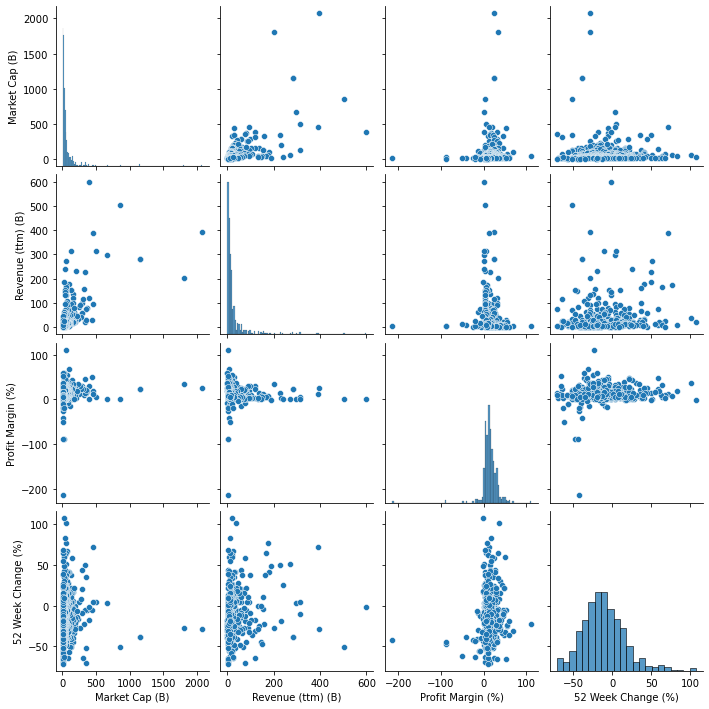

In [20]:
sns.pairplot(X);

<h2>MixMaxScaling</h2>
<p>Data to be inverse transformed after the analysis</p>

In [21]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
X.head()

,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),52 Week Change (%)
Ticker,,,,
Apple Inc. (AAPL),1.000000,0.656690,0.736196,0.235955
Microsoft Corporation (MSFT),0.869313,0.337604,0.763804,0.241573
"Amazon.com, Inc. (AMZN)",0.413740,0.836637,0.665644,0.112360
Berkshire Hathaway Inc. (BRK-B),0.322109,0.492176,0.659509,0.415730
Alphabet Inc. (GOOGL),0.554697,0.469469,0.733129,0.179775


<h3>Elbow method to determine k number of clusters</h3>

Text(0.5, 1.0, 'Elbow curve')

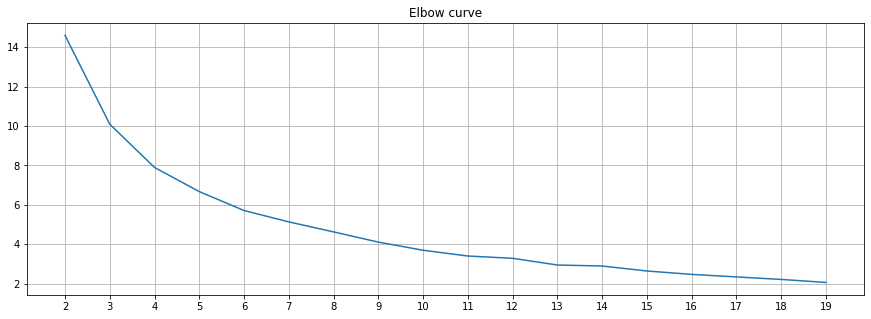

In [22]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_) #Inertia is the sum of squared distances of samples to their closest cluster center.

fig = plt.figure(figsize=(15, 5))
plt.xticks(np.arange(2,21,1))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [23]:
k = 5
model = KMeans(n_clusters=k,  
               random_state=0)

In [25]:
sp_kmeans = model.fit(X)
sp_analysis_df = pd.DataFrame(scaler.inverse_transform(X), index=X.index, columns=X.columns)
sp_analysis_df['Cluster'] = sp_kmeans.labels_

display(sp_analysis_df.sort_values(by='Cluster'))

,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),52 Week Change (%),Cluster
Ticker,,,,,
Aflac Incorporated (AFL),44.82,20.93,24.0,24.0,0
"The Williams Companies, Inc. (WMB)",40.17,11.49,17.0,24.0,0
Arthur J. Gallagher & Co. (AJG),39.63,8.25,13.0,14.0,0
Biogen Inc. (BIIB),39.46,10.36,28.0,13.0,0
"L3Harris Technologies, Inc. (LHX)",38.95,16.83,7.0,-2.0,0
...,...,...,...,...,...
UnitedHealth Group Incorporated (UNH),495.09,315.12,6.0,5.0,4
Alphabet Inc. (GOOG),1150.00,282.11,24.0,-39.0,4
CVS Health Corporation (CVS),121.88,314.34,1.0,-10.0,4


<h2>Determining Centroids and displaying the data</h2>

In [26]:
centroids_df = pd.DataFrame(scaler.inverse_transform(sp_kmeans.cluster_centers_), columns=features)
centroids_df['Cluster'] = centroids_df.index
centroids_df

,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),52 Week Change (%),Cluster
0,56.432600,24.671600,13.646667,8.360000,0
1,72.295625,70.528438,14.187500,52.468750,1
2,40.783878,20.123265,5.428571,-45.326531,2
3,52.876901,20.294601,18.643192,-18.460094,3
4,915.684000,357.849000,13.000000,-11.800000,4


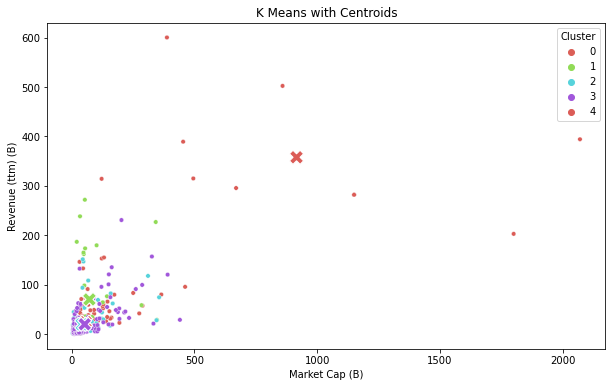

In [37]:
fig, (ax1) = plt.subplots(1,1, figsize = (10,6))

# # Scatter Plot for All Records Colored by Their Labels
ax1 = sns.scatterplot(data = sp_analysis_df, x='Market Cap (B)',y='Revenue (ttm) (B)', hue='Cluster', ax=ax1,
                palette='hls', s=20)

# Scatter Plot for Centroids
ax1 = sns.scatterplot(data = centroids_df, x='Market Cap (B)',y='Revenue (ttm) (B)', hue='Cluster', ax=ax1, 
                marker="X", palette='hls', s= 200, legend=False)

ax1.set_title("K Means with Centroids")

ax1.set_title("K Means with Centroids")
plt.show()

In [38]:
current_datetime = date.today().isoformat()
sp_analysis_df.to_csv(f'data/s&p_kmeans_{current_datetime}.csv')
print(f'Saved to file: s&p_kmeans_{current_datetime}.csv')

Saved to file: s&p_kmeans_2022-12-31.csv


In [ ]:
portfolio_df = pd.read_csv(f'data/portfolio_{current_datetime}.csv', index_col = 1)
X_test = portfolio_df[features]

sp_kmeans.predict(X_test)
